In [1]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
img_size= 128
batch_size= 16
channels= 3
epochs= 30

In [3]:
path="corn" #directory path of image set file

class_names= os.listdir(path)

In [4]:
class LabelEncoder:
    def __init__(self):
        self.classes_ = {}
        self.inverse_classes_ = {}

    def fit(self, y):
        unique_classes = np.unique(y)
        for i, class_name in enumerate(unique_classes):
            self.classes_[class_name] = i
            self.inverse_classes_[i] = class_name

    def transform(self, y):
        return np.array([self.classes_[class_name] for class_name in y])

    def inverse_transform(self, y):
        return np.array([self.inverse_classes_[class_id] for class_id in y])


le = LabelEncoder()
le.fit(class_names)

In [7]:
x,y= [],[]

for c in class_names:
    class_dir= os.path.join(path,c)
    for f in os.listdir(class_dir):
        img= Image.open(os.path.join(class_dir,f))
        img= img.resize((img_size,img_size))
        img= np.array(img)/255.0 #Normalizing pixel value between 0 and 1
        x.append(img)
        y.append(c)

In [8]:
x= np.array(x,dtype=np.float32)
y= le.transform(y)

In [10]:
def split_data(x, y, test_size=0.1, val_size=0.2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)

    total_size = len(x)
    test_size = int(total_size * test_size)
    val_size = int(total_size * val_size)

    indices = np.arange(total_size)
    np.random.shuffle(indices)

    test_indices = indices[:test_size]
    val_indices = indices[test_size:test_size + val_size]
    train_indices = indices[test_size + val_size:]

    x_test = x[test_indices]
    y_test = y[test_indices]

    x_val = x[val_indices]
    y_val = y[val_indices]

    x_train = x[train_indices]
    y_train = y[train_indices]

    return x_train, x_val, x_test, y_train, y_val, y_test

x_train,x_val,x_test,y_train,y_val,y_test= split_data(x,y, test_size=0.1, val_size=0.2, random_state=42)

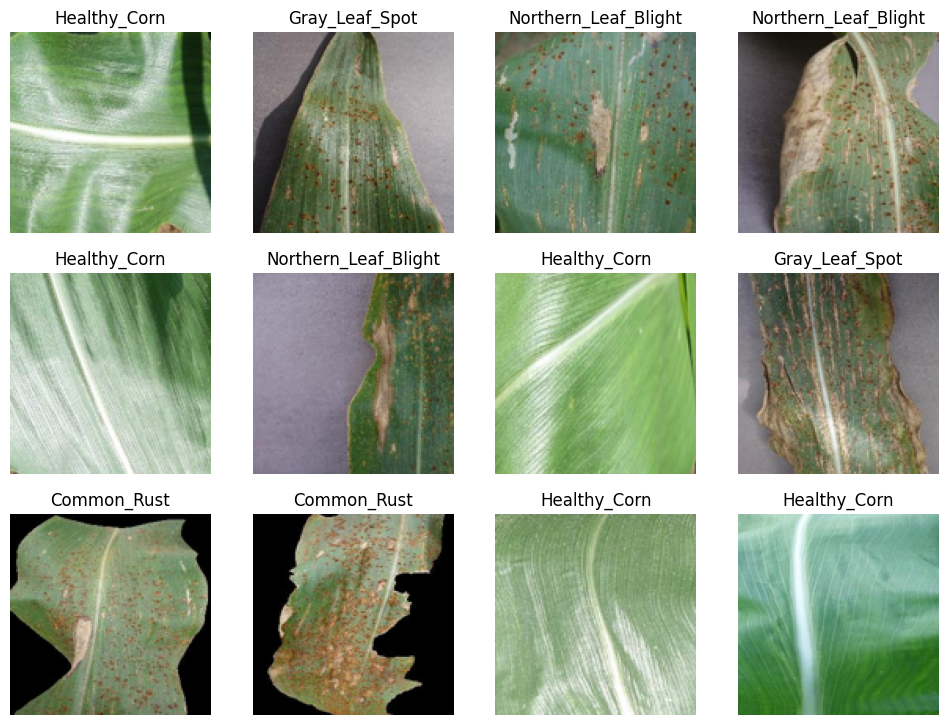

In [11]:
import random
plt.figure(figsize=(12,12))
ri = random.sample(range(len(x_train)), 12)
for i, idx in enumerate(ri):
    plt.subplot(4,4,i+1)
    plt.imshow(x_train[idx])
    plt.title(class_names[y_train[idx]])
    plt.axis("off")
    
plt.show()

In [12]:
def relu(x):
    return np.maximum(0,x)
def softmax(x):
    ex= np.exp(x- np.max(x, axis=-1, keepdims=True))
    return ex/ ex.sum(axis=-1, keepdims=True)
def initialize_parameters(input_size, output_size):
    weights = np.random.randn(input_size, output_size)
    bias = np.zeros((1, output_size))
    return weights, bias
def dense_forward(x, weights, bias, activation='relu'):
    z = np.dot(x, weights) + bias
    if activation == 'relu':
        return relu(z)
    elif activation == 'softmax':
        return softmax(z)
    return z
# Define a function to compute the categorical cross-entropy loss
def categorical_crossentropy(predictions, targets):
    num_samples = len(targets)
    loss = -np.sum(np.log(predictions[np.arange(num_samples), targets] + 1e-12)) / num_samples
    return loss
# Define a function to compute the gradient of the loss with respect to predictions
def gradient_loss(predictions, targets):
    grad_loss = predictions
    grad_loss[np.arange(len(targets)), targets] -= 1
    grad_loss /= len(targets)
    return grad_loss
input_size = img_size * img_size * channels
hidden_units = 128
output_size = len(class_names)

wr1, br1 = initialize_parameters(input_size, hidden_units)
wr2, br2 = initialize_parameters(hidden_units, output_size)


In [13]:
learning_rate = 0.001

# Define lists to collect loss values
training_losses = []
validation_losses = []

epochs= 30

for epoch in range(epochs):
    for i in range(0, len(x_train), batch_size):
        x_batch = x_train[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]

        # Forward pass
        hidden_layer = dense_forward(x_batch.reshape(-1, input_size), wr1, br1, activation='relu')
        predictions = dense_forward(hidden_layer, wr2, br2, activation='softmax')

        # Loss
        loss = categorical_crossentropy(predictions, y_batch)

        # Backward pass
        grad_loss = gradient_loss(predictions, y_batch)

        grad_hidden = np.dot(grad_loss, wr2.T)
        grad_weights2 = np.dot(hidden_layer.T, grad_loss)
        grad_bias2 = np.sum(grad_loss, axis=0, keepdims=True)

        grad_hidden[hidden_layer <= 0] = 0  # ReLU backward
        grad_weights1 = np.dot(x_batch.reshape(-1, input_size).T, grad_hidden)
        grad_bias1 = np.sum(grad_hidden, axis=0, keepdims=True)

        # Update weights and biases
        wr2 -= learning_rate * grad_weights2
        br2 -= learning_rate * grad_bias2
        wr1 -= learning_rate * grad_weights1
        br1 -= learning_rate * grad_bias1

    
    hidden_layer_val = dense_forward(x_val.reshape(-1, input_size), wr1, br1, activation='relu')
    val_predictions = dense_forward(hidden_layer_val, wr2, br2, activation='softmax')
    val_loss = categorical_crossentropy(val_predictions, y_val)
    
    # Append training and validation loss to the lists
    training_losses.append(loss)
    validation_losses.append(val_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}, Validation Loss: {val_loss:.4f}")
    
# Save trained model parameters
np.save("wc1.npy", wr1)
np.save("bc1.npy", br1)
np.save("wc2.npy", wr2)
np.save("bc2.npy", br2)

Epoch 1/30, Loss: 12.2780, Validation Loss: 10.6648
Epoch 2/30, Loss: 8.0226, Validation Loss: 7.5962
Epoch 3/30, Loss: 6.1251, Validation Loss: 5.8408
Epoch 4/30, Loss: 0.0000, Validation Loss: 5.4212
Epoch 5/30, Loss: 6.2002, Validation Loss: 5.8197
Epoch 6/30, Loss: 3.0701, Validation Loss: 5.5843
Epoch 7/30, Loss: 4.9939, Validation Loss: 5.9256
Epoch 8/30, Loss: 4.5721, Validation Loss: 5.8250
Epoch 9/30, Loss: 3.9829, Validation Loss: 6.3778
Epoch 10/30, Loss: 4.7888, Validation Loss: 5.3379
Epoch 11/30, Loss: 3.0701, Validation Loss: 5.1374
Epoch 12/30, Loss: 3.7659, Validation Loss: 6.8845
Epoch 13/30, Loss: 0.0153, Validation Loss: 5.4572
Epoch 14/30, Loss: 1.2235, Validation Loss: 4.5213
Epoch 15/30, Loss: 0.1121, Validation Loss: 5.5328
Epoch 16/30, Loss: 0.0039, Validation Loss: 4.8367
Epoch 17/30, Loss: 0.1016, Validation Loss: 5.6001
Epoch 18/30, Loss: 0.7726, Validation Loss: 6.6191
Epoch 19/30, Loss: 0.4644, Validation Loss: 4.4522
Epoch 20/30, Loss: 0.5123, Validation 

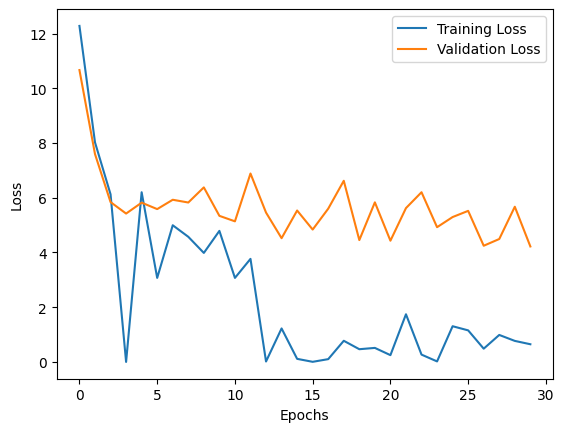

Test Accuracy: 77.14%


In [14]:
# Plot the loss vs. validation loss graph
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Define a function to make predictions
def predict(x, weights1, bias1, weights2, bias2):
    hidden_layer = dense_forward(x.reshape(-1, input_size), weights1, bias1, activation='relu')
    predictions = dense_forward(hidden_layer, weights2, bias2, activation='softmax')
    return np.argmax(predictions, axis=1)

# Make predictions on the test set
test_predictions = predict(x_test, wr1, br1, wr2, br2)

# Calculate accuracy
accuracy = np.mean(test_predictions == y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")